In [1]:
import matplotlib.pyplot as plt
import matplotlib
from pylab import figure, text, scatter, show
import sys, math, numpy
import seaborn as sns
sns.set_theme()
sns.set_style(style='white')
sns.set_style("ticks")

In [2]:
def get_cluster_label(sysname):
    """Get the labels for each cluster."""
    return numpy.load(f"../4.dim_red/clusters_{sysname}.npy")

def get_latent_displacement(sysname, edge):
    """Get the latent displacement from feature perturbation."""
    _lt_basedir = "/scratch/users/zilins/6.proj_ges_imi/3.gnn/model_latent_pert"
    _ds_basedir = "/scratch/users/zilins/6.proj_ges_imi/2.datasets/rawds"
    edge_latent = numpy.load(f"{_lt_basedir}/{sysname}_pert_latent.npy")
    edge_label  = numpy.load(f"{_ds_basedir}/label_edges.npy")
    latent = edge_latent[:, numpy.squeeze(numpy.where(edge==edge_label)), :]
    return numpy.sum(numpy.abs(latent), axis=1)

edge_list = ["SER.64.OG:LYS.67.HZ1",     "GLU.161.OE1:TIP3.287.H1",  "IMI.286.C7:TIP3.287.OH2",
             "SER.64.OG:LYS.67.HZ3",     "ASN.127.OD1:LYS.67.HZ2",   "ASN.127.OD1:IMI.286.H15O", "GLU.161.OE1:LYS.67.HZ2", 
             "GLU.161.OE2:SER.165.HG1",  "GLU.161.OE1:IMI.286.H15O", "SER.165.OG:TIP3.287.H2",   "IMI.286.O15:LYS.67.HZ1",   
             "IMI.286.O15:ASN.127.HD22", "IMI.286.C7:IMI.286.O15",   "TIP3.287.OH2:LYS.67.HZ1",  "TIP3.287.OH2:IMI.286.H15O",
             "SER.64.OG:SER.64.HG1",     "IMI.286.O7:SER.64.HG1"
            ]
edge_label= [r"Ser70 O$\gamma$ - Lys73 H$\zeta$1",      r"Glu166 O$\epsilon$1 - Water H1",        "IPM C7 - Water O",
             r"Ser70 O$\gamma$ - Lys73 H$\zeta$3",      r"Asn132 O$\delta$ - Lys73 H$\zeta$2",    r"Asn132 O$\delta$ - IPM HO6$\alpha$",  r"Glu166 O$\epsilon$1 - Lys73 H$\zeta$2",
             r"Glu166 O$\epsilon$2 - Ser170 H$\gamma$", r"Glu166 O$\epsilon$1 - IPM HO6$\alpha$", r"Ser170 O$\gamma$ - Water H2", r"IPM O6$\alpha$ - Lys73 H$\zeta$1",
             r"IPM O6$\alpha$ - Asn132 H$\delta$2",     r"IPM C7 - IPM O6$\alpha$",               r"Water O - Lys73 H$\zeta$1",   r"Water O - IPM HO6$\alpha$",
             r"Ser70 O$\gamma$ - IPM H4",     "IPM O7 - IPM H4"]

d1_latent_displacement = numpy.asarray([get_latent_displacement('d1', el) for el in edge_list[:-2]]).T
d2_latent_displacement = numpy.asarray([get_latent_displacement('d2', el) for el in edge_list     ]).T

## hypothesis tests.
A p-value larger than a chosen threshold (e.g. 5% or .1%) indicates that our observation is not so unlikely to have occurred by chance.  
Therefore, we do not reject (accept) the null hypothesis of equal population means.  
If the p-value is smaller than our threshold, then we have evidence against the null hypothesis of (same distributions - ks test) or (equal population means - welch test).
# KS test for normality.

In [25]:
from scipy.stats import gaussian_kde, kstest
print(".... KS test for normality as PDF.")

print(d1_latent_displacement.shape)
print(d2_latent_displacement.shape)

print('d1 tests')
d1_expectation = []
d1_error_high  = []
d1_error_low   = []
for i in range(d1_latent_displacement.shape[1]):
    x        = d1_latent_displacement[:, i]
    x_std    = numpy.std(x)
    x_norm   = (x-numpy.mean(x)) / x_std
    k        = gaussian_kde(x_norm)
    k_pdf    = k.pdf(x_norm)
    samp_pdf = k.resample(500).flatten()
    ks, p = kstest(x_norm, samp_pdf)
    
    expectation = numpy.sum(x*k_pdf)/numpy.sum(k_pdf)
    d1_expectation.append(expectation)
    
    # bootstrap for expectation error analysis. 
    errors = []
    for _ in range(10):
        sub_x      = numpy.random.choice(x, size=100, replace=False)
        sub_x_std  = numpy.std(sub_x)
        sub_x_norm = (sub_x-numpy.mean(sub_x)) / sub_x_std
        sub_k      = gaussian_kde(sub_x_norm)
        sub_k_pdf  = sub_k.pdf(sub_x_norm)
        sub_expectation = numpy.sum(sub_x*sub_k_pdf)/numpy.sum(sub_k_pdf)
        
        errors.append(sub_expectation - expectation)
    
    d1_error_high.append(numpy.max(errors))
    d1_error_low.append(numpy.min(errors))
    print(f"{edge_label[i]:>50} {ks:>10} {p:>20} {expectation:>20} {x_std:>20} {numpy.max(errors):>20} {numpy.min(errors)}")
    
print('\nd2 tests')

d2_expectation = []
d2_error_high  = []
d2_error_low   = []
for i in range(d2_latent_displacement.shape[1]):
    x        = d2_latent_displacement[:, i]
    x_std    = numpy.std(x)
    x_norm   = (x-numpy.mean(x)) / x_std
    k        = gaussian_kde(x_norm)
    k_pdf    = k.pdf(x_norm)
    samp_pdf = k.resample(500).flatten()
    ks, p = kstest(x_norm, samp_pdf)
    
    expectation = numpy.sum(x*k_pdf)/numpy.sum(k_pdf)
    d2_expectation.append(expectation)
    # bootstrap for expectation error analysis. 
    errors = []
    for _ in range(10):
        sub_x      = numpy.random.choice(x, size=100, replace=False)
        sub_x_std  = numpy.std(sub_x)
        sub_x_norm = (sub_x-numpy.mean(sub_x)) / sub_x_std
        sub_k      = gaussian_kde(sub_x_norm)
        sub_k_pdf  = sub_k.pdf(sub_x_norm)
        sub_expectation = numpy.sum(sub_x*sub_k_pdf)/numpy.sum(sub_k_pdf)
        
        errors.append(sub_expectation - expectation)
    
    d2_error_high.append(numpy.max(errors))
    d2_error_low.append(numpy.min(errors))
    print(f"{edge_label[i]:>50} {ks:>10} {p:>20} {expectation:>20} {x_std:>20} {numpy.max(errors):>20} {numpy.min(errors)}")

.... KS test for normality as PDF.
(500, 15)
(500, 17)
d1 tests
                 Ser70 O$\gamma$ - Lys73 H$\zeta$1       0.07   0.1725563396262406   2.0751797350075916   1.3679322004318237  0.07586639962052022 -0.09826574493762252
                    Glu166 O$\epsilon$1 - Water H1      0.058   0.3699050405997647    1.150889801091903   0.6450715065002441  0.06500176541230362 -0.028790090498297838
                                  IPM C7 - Water O      0.058   0.3699050405997647   6.0548715505357436   1.7483928203582764  0.21365977435031436 -0.2767634716924334
                 Ser70 O$\gamma$ - Lys73 H$\zeta$3       0.07   0.1725563396262406   2.6117761552521257   1.5151504278182983  0.18921479953829046 -0.19567973724593157
                Asn132 O$\delta$ - Lys73 H$\zeta$2      0.066  0.22634729051389657    4.142832525234021   1.2312405109405518   0.1434378347923131 -0.16742988436537454
                Asn132 O$\delta$ - IPM HO6$\alpha$       0.05   0.5600220048872044   3.00188502022851

# Welch test for d1 vs d2.

In [24]:
from scipy.stats import ttest_ind, mannwhitneyu
print(".... d1 vs d2 Welch's t-test")

sig_d1_d2      = []
very_sig_d1_d2 = []

for i in range(d1_latent_displacement.shape[1]):
    d_1 = d1_latent_displacement[:, i]
    d_2 = d2_latent_displacement[:, i]
    ks, p = ttest_ind(d_1, d_2, equal_var=False) # , permutations=numpy.inf)
    if p < 0.05 and p >= 0.001: 
        print(i, ks, p, "~~~")
        sig_d1_d2.append(i)
    elif p < 0.001 :
        print(i, ks, p, "!!!!")
        very_sig_d1_d2.append(i)
    else:
        print(i, ks, p)

.... d1 vs d2 Welch's t-test
0 -3.251027311035307 0.0011886322855384122 ~~~
1 -18.889750109876104 7.908948233517308e-68 !!!!
2 3.9108294745346517 9.82028392225108e-05 !!!!
3 -0.7445144851220288 0.45675194254187823
4 2.9633833960631044 0.003115050461619584 ~~~
5 -3.868977165445234 0.0001168122340430546 !!!!
6 -1.4338716997192424 0.15192240765047502
7 2.810752979259495 0.005039642768397601 ~~~
8 -6.282277487787571 5.037157904061476e-10 !!!!
9 1.3463981346536964 0.17848705190842104
10 4.294308463393616 1.9298415743156786e-05 !!!!
11 2.369998813361463 0.017977489342174746 ~~~
12 1.3390364624598468 0.18086501770707272
13 0.8461347696206474 0.39768043522939334
14 -0.25281425451682366 0.800465578573837


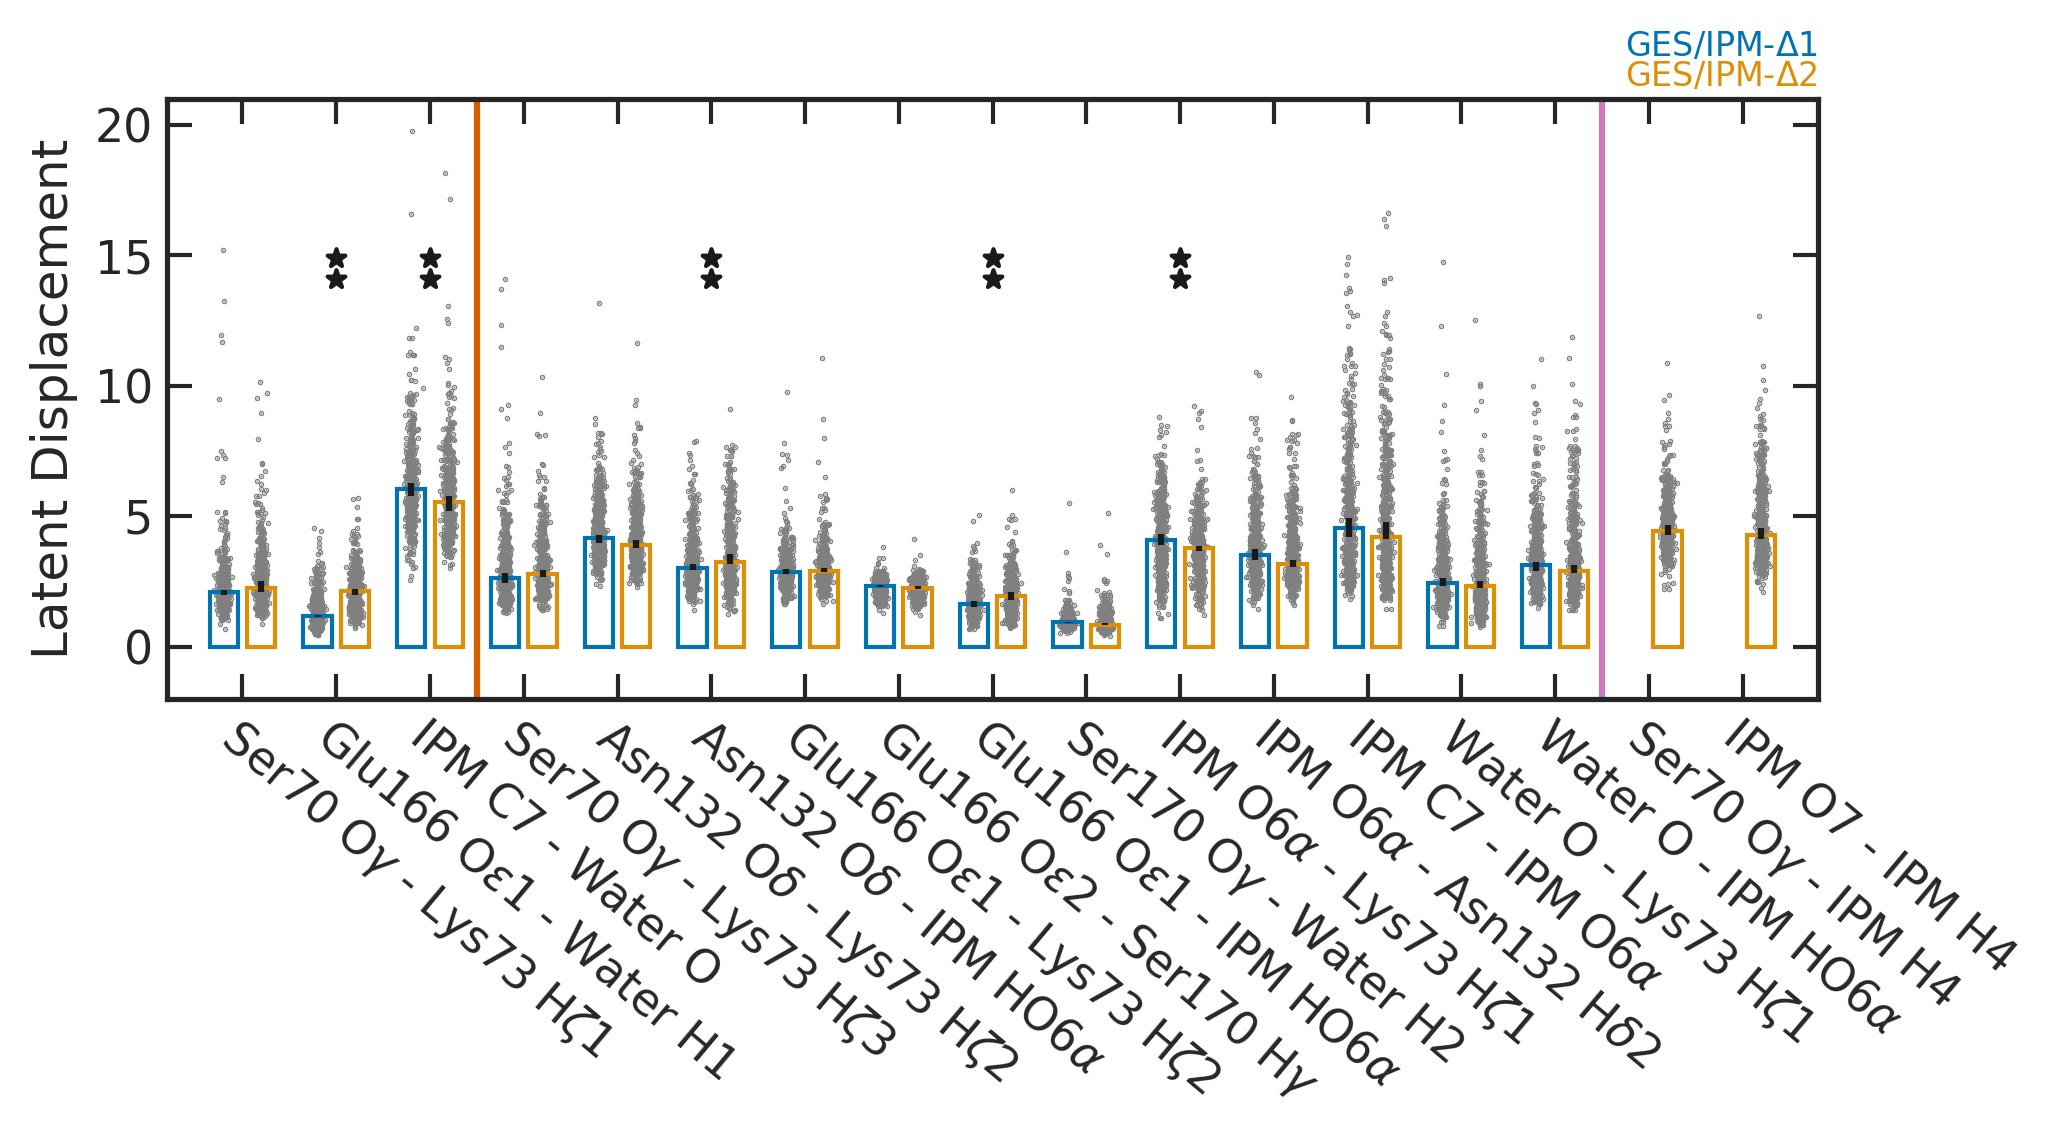

In [84]:
fig, axes  = plt.subplots(figsize=(7.5, 4.), dpi=300, facecolor='w', edgecolor='k', )
plt.subplots_adjust(left=1./7.5, right=6.5/7.5, top=3.5/4., bottom=1.5/4.)

ax = axes

# ===  sns.color_palette('colorblind')[1]
y_d1 = numpy.arange(d1_latent_displacement.shape[1])
y_d2 = numpy.arange(d2_latent_displacement.shape[1])
# ===
ax.text(1., 1.06, r'GES/IPM-$\Delta$1', ha='right', va='bottom', transform=ax.transAxes, fontsize=8, color=sns.color_palette('colorblind')[0])
ax.text(1., 1.01, r'GES/IPM-$\Delta$2', ha='right', va='bottom', transform=ax.transAxes, fontsize=8, color=sns.color_palette('colorblind')[1])
# ===
d1_bars = ax.bar(x=y_d1-0.20, height=d1_expectation, width=0.3, yerr=numpy.abs(numpy.asarray([d1_error_low, d1_error_high])), 
                 fill=False, edgecolor=sns.color_palette('colorblind')[0],
                 error_kw=dict(ecolor='k'))
d2_bars = ax.bar(x=y_d2+0.20, height=d2_expectation, width=0.3, yerr=numpy.abs(numpy.asarray([d2_error_low, d2_error_high])), 
                 fill=False, edgecolor=sns.color_palette('colorblind')[1],
                 error_kw=dict(ecolor='k'))
# ===
for i in range(d1_latent_displacement.shape[1]):
    ax.scatter(y=d1_latent_displacement[:, i], x=numpy.random.normal(loc=y_d1[i]-0.20, scale=0.03, size=d1_latent_displacement.shape[0]), s=0.1, color='gray', zorder=0)
for i in range(d2_latent_displacement.shape[1]):
    ax.scatter(y=d2_latent_displacement[:, i], x=numpy.random.normal(loc=y_d2[i]+0.20, scale=0.03, size=d2_latent_displacement.shape[0]), s=0.1, color='gray', zorder=0)
# for i in range(d1_latent_displacement.shape[0]):
#     ax.scatter(y=d2_latent_displacement[i, :]-d1_latent_displacement[i,:], x=numpy.random.normal(loc=y_d1[i], scale=0.03, size=d2_latent_displacement.shape[1]), s=0.1, color='k')

# ===
ax.plot([ 2.5,  2.5], [-2, 21], c=sns.color_palette('colorblind')[3], lw=1.5, zorder=1)
ax.plot([14.5, 14.5], [-2, 21], c=sns.color_palette('colorblind')[4], lw=1.5, zorder=1)
# ===
ax.scatter(y=numpy.ones(len(very_sig_d1_d2))*-.1+15, 
           x=very_sig_d1_d2, s=20, color='k', marker='*')
ax.scatter(y=numpy.ones(len(very_sig_d1_d2))*-.9+15, 
           x=very_sig_d1_d2, s=20, color='k', marker='*')
# ax.scatter(y=numpy.ones(len(sig_d1_d2))*-.5+15, 
#            x=sig_d1_d2, s=20, color='k', marker='*')


ax.set_xticks(numpy.arange(0, len(edge_label)))
ax.set_xticklabels(edge_label, ha='left', va='top', rotation=-40, rotation_mode="anchor")

ax.tick_params(which='major', direction='in', length=6, width=1)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.set_xlim(-0.8, 16.8)
ax.set_ylim(-2, 21)
ax.set_ylabel(r'Latent Displacement')

fig.savefig(f'latent_distri.png')

In [8]:

# Welch’s t-test
print(".... d1 vs d1")
for i in range(d1_latent_displacement.shape[1]):
    
    for j in range(i+1, d1_latent_displacement.shape[1]):
        d_i = d1_latent_displacement[:, i]
        d_j = d1_latent_displacement[:, j]
        ks, p = ttest_ind(d_i, d_j, equal_var=False) # , permutations=numpy.inf)
        if p > 0.05: print(i, j, ks, p)

print(".... d2 vs d2")            
for i in range(d2_latent_displacement.shape[1]):
    
    for j in range(i+1, d2_latent_displacement.shape[1]):
        d_i = d2_latent_displacement[:, i]
        d_j = d2_latent_displacement[:, j]
        ks, p = ttest_ind(d_i, d_j, equal_var=False) # , permutations=numpy.inf)
        if p > 0.05: print(i, j, ks, p)

for i in range(15):
    print(i, numpy.average(d1_latent_displacement, axis=0)[i])
    
print("---")
for i in range(15):
    print(i, numpy.average(d2_latent_displacement, axis=0)[i])

.... d1 vs d1
0 7 1.687682655627695 0.09202863867722431
3 6 1.1059891189073796 0.26907039153541246
6 13 1.5902772426419356 0.1121713953918021
.... d2 vs d2
0 13 -1.5261073953497948 0.1273102742972624
1 7 0.27610778098513133 0.7825478937013158
3 6 1.093644541250769 0.27439546093969513
5 11 -0.3278614487808572 0.743085190985636
5 14 1.0886067700348188 0.27659989584961536
11 14 1.384420671247289 0.16655098020007647
15 16 -0.850622842576284 0.39519949565159584
0 2.396061
1 1.3635302
2 6.337535
3 3.0895586
4 4.49249
5 3.3534985
6 3.0035684
7 2.2895715
8 1.765715
9 1.0066794
10 4.2318864
11 3.8948238
12 5.370321
13 2.8814583
14 3.5274384
---
0 2.6666572
1 2.23812
2 5.9082866
3 3.1533082
4 4.258447
5 3.6589491
6 3.0818598
7 2.2271757
8 2.034772
9 0.9735387
10 3.8728135
11 3.687766
12 5.151288
13 2.8010561
14 3.5522969


In [ ]:
from sklearn.feature_selection import mutual_info_regression

dkl = []
latent_displacement = d1_latent_displacement
print(latent_displacement.shape)

for i in range(latent_displacement.shape[1]):
    dkl_i = []
    
    for j in range(latent_displacement.shape[1]):
        x = latent_displacement[:, i]
        y = latent_displacement[:, j]
        x = x.reshape(-1, 1)
        dkl_i.append(mutual_info_regression(x, y))
    
    dkl.append(dkl_i)
    
    
dkl = numpy.squeeze(numpy.asarray(dkl), axis=2)
print(dkl.shape)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)

# Generate a mask for the upper triangle
mask = numpy.tril(numpy.ones_like(dkl, dtype=bool))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(dkl, mask=mask, cmap=cmap, vmax=0, vmin=0.25,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.set_xticklabels(edge_label[:15], rotation=90)
ax.set_yticklabels(edge_label[:15], rotation=0)
ax.xaxis.set_ticks_position('top')

(500, 15)
